In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
report_file = 'battery-report.html'

In [3]:
tables = pd.read_html(report_file)

### Supporting Functions

In [255]:
def get_date(x):
    if len(x) == 19:
        return x.split(' ')[0]
    return np.nan
def get_time(x):
    if len(x) == 19:
        return x.split(' ')[1]
    return x

def get_minutes(x):
    return int(pd.Timedelta(x).total_seconds()/60)

def handle_time(df,col,drop=True):
    df['Date'] = df[col].apply(get_date)
    df['Date'] = df['Date'].ffill()
    df['Time'] = df[col].apply(get_time)
    df[col] = pd.to_datetime(df['Date']+' '+df['Time'], format='%Y-%m-%d %H:%M:%S')
    if drop:
        df.drop(['Date','Time'],axis=1,inplace=True)
        
def handle_duration(df,col):
    df[col] = df[col].apply(get_minutes)

def remove_percent(df,col):
    df[col] = df[col].str.replace(' %','').astype(float)

def remove_mwh(df, col):
    df[col] = df[col].str.replace(',', '').str.replace(' mWh', '').astype(float)

### Basic Info

In [23]:
basic_info = tables[0]
pprint(basic_info)

                     0                                        1
0        COMPUTER NAME                                   ALPHA1
1  SYSTEM PRODUCT NAME                     Acer Aspire A515-57G
2                 BIOS                         V1.08 04/25/2022
3             OS BUILD  22621.1.amd64fre.ni_release.220506-1250
4        PLATFORM ROLE                                   Mobile
5    CONNECTED STANDBY                                Supported
6          REPORT TIME                      2024-11-10 19:44:43


In [ ]:
basic_info.to_json()

'{"0":{"0":"COMPUTER NAME","1":"SYSTEM PRODUCT NAME","2":"BIOS","3":"OS BUILD","4":"PLATFORM ROLE","5":"CONNECTED STANDBY","6":"REPORT TIME"},"1":{"0":"ALPHA1","1":"Acer Aspire A515-57G","2":"V1.08 04\\/25\\/2022","3":"22621.1.amd64fre.ni_release.220506-1250","4":"Mobile","5":"Supported","6":"2024-11-10 19:44:43"}}'

### Battery Info

In [21]:
battery_info = tables[1]
pprint(battery_info)

             Unnamed: 0  BATTERY  1
0                  NAME     AP20CBL
1          MANUFACTURER       COSMX
2         SERIAL NUMBER        1979
3             CHEMISTRY        Li-I
4       DESIGN CAPACITY  53,015 mWh
5                   NaN         NaN
6  FULL CHARGE CAPACITY  42,146 mWh
7           CYCLE COUNT           -


### Recent usage table

In [22]:
recent = tables[2].copy()
recent.head(5)

,START TIME,STATE,SOURCE,CAPACITY REMAINING,CAPACITY REMAINING.1
0,2024-11-07 19:47:47,Active,Battery,100 %,"42,146 mWh"
1,21:48:13,Connected standby,Battery,32 %,"13,340 mWh"
2,21:48:18,Suspended,NaN,32 %,"13,283 mWh"
3,2024-11-08 07:40:25,Connected standby,Battery,30 %,"12,763 mWh"
4,07:41:00,Active,Battery,30 %,"12,474 mWh"


In [ ]:
def get_usage_plot(df):
    plt.figure(figsize=(10,4), facecolor='white')
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot the entire line in blue
    plt.plot(df['START TIME'], df['CAPACITY REMAINING'], 
            color='#1E90FF',  # Dodger blue
            linewidth=2, 
            alpha=0.7)

    # Set plot title and axis labels
    start_day = df['START TIME'].min().date()
    end_day = df['START TIME'].max().date()
    plt.title(f'Battery Consumption between {start_day} - {end_day}', 
            fontsize=14, fontweight='bold', color='#333333')
    plt.xlabel('Start Time', fontsize=10, color='#666666')
    plt.ylabel('Capacity Remaining (%)', fontsize=10, color='#666666')

    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n %d/%m'))
    plt.xticks(rotation=0, ha='right', fontsize=8, color='#666666')
    plt.yticks(fontsize=8, color='#666666')

    # Set x-axis limits and ticks
    plt.xlim(df['START TIME'].min(), df['START TIME'].max())
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

    # Add grid
    plt.grid(True, linestyle='--', linewidth=0.5, color='#E0E0E0')

    plt.tight_layout()

In [9]:
handle_time(recent,'START TIME',drop=False)
remove_percent(recent,'CAPACITY REMAINING')
recent.head(5)

,START TIME,STATE,SOURCE,CAPACITY REMAINING,CAPACITY REMAINING.1,Date,Time
0,2024-11-07 19:47:47,Active,Battery,100.0,"42,146 mWh",2024-11-07,19:47:47
1,2024-11-07 21:48:13,Connected standby,Battery,32.0,"13,340 mWh",2024-11-07,21:48:13
2,2024-11-07 21:48:18,Suspended,NaN,32.0,"13,283 mWh",2024-11-07,21:48:18
3,2024-11-08 07:40:25,Connected standby,Battery,30.0,"12,763 mWh",2024-11-08,07:40:25
4,2024-11-08 07:41:00,Active,Battery,30.0,"12,474 mWh",2024-11-08,07:41:00


<module 'matplotlib.pyplot' from 'c:\\Users\\Sufya\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\battery-report-analysis-6fU-tPu0-py3.11\\Lib\\site-packages\\matplotlib\\pyplot.py'>

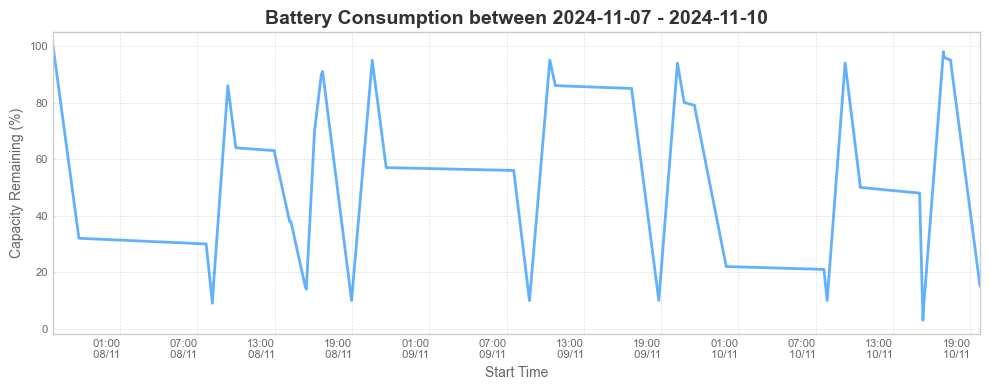

In [10]:
get_usage_plot(recent)

### Battry Useage Table

In [235]:
battery = tables[3].copy()
battery = battery.dropna(axis=0, how='any')
battery['ENERGY DRAINED'] = battery['ENERGY DRAINED'].replace('-',np.nan)
battery.head(5)

,START TIME,STATE,DURATION,ENERGY DRAINED,ENERGY DRAINED.1
0,2024-11-07 19:47:47,Active,2:00:26,68 %,"28,806 mWh"
1,21:48:13,Connected standby,0:00:04,NaN,57 mWh
3,2024-11-08 07:40:25,Connected standby,0:00:35,1 %,289 mWh
4,07:41:00,Active,0:28:59,21 %,"8,801 mWh"
6,08:15:34,Active,0:00:06,NaN,23 mWh


In [137]:
handle_time(battery,'START TIME',drop=False)
remove_percent(battery,'ENERGY DRAINED')
handle_duration(battery,'DURATION')
battery.head(2)

,START TIME,STATE,DURATION,ENERGY DRAINED,ENERGY DRAINED.1,Date,Time
0,2024-11-07 19:47:47,Active,120,68.0,"28,806 mWh",2024-11-07,19:47:47
1,2024-11-07 21:48:13,Connected standby,0,NaN,57 mWh,2024-11-07,21:48:13


#### Details about last 36 hrs 

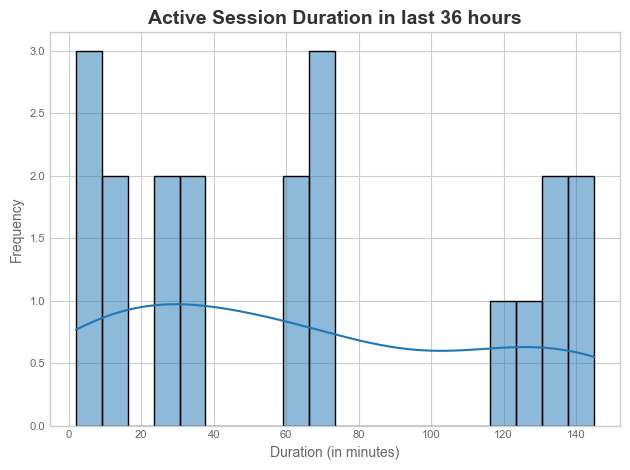

In [218]:
plt.title('Active Session Duration in last 36 hours', fontsize=14, fontweight='bold', color='#333333')
sns.histplot(battery['DURATION'][battery['DURATION']>0],kde=True,bins=20)
plt.xlabel('Duration (in minutes)', fontsize=10, color='#666666')
plt.ylabel('Frequency', fontsize=10, color='#666666')
plt.xticks(fontsize=8, color='#666666')
plt.yticks(fontsize=8, color='#666666')
plt.tight_layout()

plt.show()

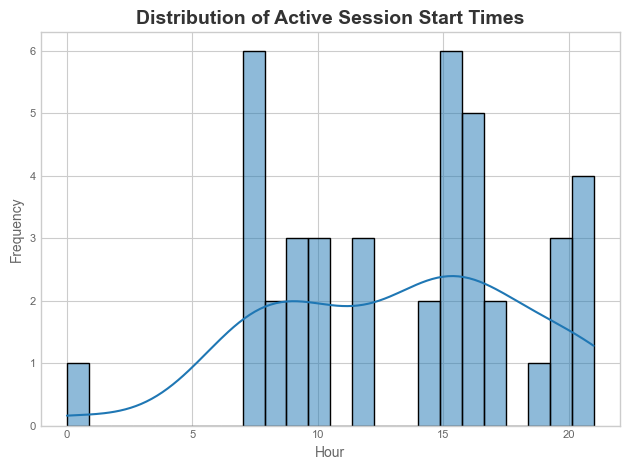

In [226]:
plt.title('Distribution of Active Session Start Times', fontsize=14, fontweight='bold', color='#333333')
sns.histplot(battery['START TIME'].dt.hour,kde=True,bins=24)
plt.xlabel('Hour', fontsize=10, color='#666666')
plt.ylabel('Frequency', fontsize=10, color='#666666')
plt.xticks(fontsize=8, color='#666666')
plt.yticks(fontsize=8, color='#666666')
plt.tight_layout()
plt.show()

In [268]:
def analyze_battery_data(df):
    #) Preprocessing with helper functions
    df = df.dropna(axis=0, how='any')
    df['ENERGY DRAINED'] = df['ENERGY DRAINED'].replace('-',np.nan)
    df['ENERGY DRAINED.1'] = df['ENERGY DRAINED.1'].replace('-',np.nan)
    handle_time(df, 'START TIME')  # Parse and split 'START TIME' into datetime
    handle_duration(df, 'DURATION')  # Convert 'DURATION' to minutes
    remove_percent(df, 'ENERGY DRAINED')  # Clean and convert 'ENERGY DRAINED' column
    remove_mwh(df, 'ENERGY DRAINED.1')  # Clean and convert 'ENERGY DRAINED.1' column

    # Total energy drained
    total_energy_drained = df['ENERGY DRAINED.1'].sum()

    # Total time in active and standby states
    total_active_time = df.loc[df['STATE'] == 'Active', 'DURATION'].sum()
    total_standby_time = df.loc[df['STATE'] == 'Connected standby', 'DURATION'].sum()

    # Average energy drained per state
    avg_energy_drained_active = df.loc[df['STATE'] == 'Active', 'ENERGY DRAINED.1'].mean()
    avg_energy_drained_standby = df.loc[df['STATE'] == 'Connected standby', 'ENERGY DRAINED.1'].mean()
    
    # Longest and shortest active periods
    longest_active_period = df.loc[df['STATE'] == 'Active', 'DURATION'].max()
    shortest_active_period = df.loc[df['STATE'] == 'Active', 'DURATION'].min()

    # Daily usage patterns
    df['Date'] = df['START TIME'].dt.date  # Extract the date
    daily_energy_usage = df.groupby('Date')['ENERGY DRAINED.1'].sum()  # Total energy per day
    daily_active_time = df[df['STATE'] == 'Active'].groupby('Date')['DURATION'].sum()  # Active time per day

    # Results summary
    results = {
        "Total Energy Drained (mWh)": str(total_energy_drained.round(2)),
        "Total Active Time (minutes)": str(total_active_time.round(2)),
        "Total Standby Time (minutes)": str(total_standby_time.round(2)),
        "Average Energy Drained in Active State (mWh)": str(avg_energy_drained_active.round(2)),
        "Average Energy Drained in Standby (mWh)": str(avg_energy_drained_standby.round(2)),
        "Longest Active Period (minutes)": str(longest_active_period.round(2)),
        "Shortest Active Period (minutes)": str(shortest_active_period.round(2)),
        "Daily Energy Usage (mWh)": daily_energy_usage,
        "Daily Active Time (minutes)": daily_active_time
    }

    return results


In [ ]:
analyze_battery_data(tables[3].copy())

{'Total Energy Drained (mWh)': '277835.0',
 'Total Active Time (minutes)': '1151',
 'Total Standby Time (minutes)': '149',
 'Average Energy Drained in Active State (mWh)': '13734.7',
 'Average Energy Drained in Standby (mWh)': '165.32',
 'Longest Active Period (minutes)': '145',
 'Shortest Active Period (minutes)': '0',
 'Daily Energy Usage (mWh)': Date
 2024-11-07    28863.0
 2024-11-08    88739.0
 2024-11-09    84511.0
 2024-11-10    75722.0
 Name: ENERGY DRAINED.1, dtype: float64,
 'Daily Active Time (minutes)': Date
 2024-11-07    120
 2024-11-08    398
 2024-11-09    399
 2024-11-10    234
 Name: DURATION, dtype: int64}

: 